In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import json
from tensorflow import keras
from keras import layers
from skimage.restoration import denoise_tv_chambolle

from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
N = 3
T = 32
D = 0.1
total_range = T+200

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list).copy()

In [4]:
def shuffle(data, *args):
    shuffle_index = np.arange(data.shape[0])
    np.random.shuffle(shuffle_index)
    args = list(args)
    for i, arg in enumerate(args):
        args[i] = arg[shuffle_index]
    return data[shuffle_index], *args

In [5]:
input_data = []
input_label = []

for i in range(10000):
    alpha = np.random.uniform(low=0.001, high=1.999)
    #alpha = np.random.choice([0.01, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 1.99], 1)[0]
    trajs_model, labels_model = models_phenom().single_state(N=N,
                                                            L=None,
                                                            T=total_range,
                                                            alphas=alpha,  # Fixed alpha for each state
                                                            Ds=[D, 0],# Mean and variance of each state
                                                           )
    for n_traj in range(N):
        xs = trajs_model[:, n_traj, 0][:T]
        ys = trajs_model[:, n_traj, 1][:T]
        xs = xs / (np.std(xs))
        xs = np.cumsum(abs(uncumulate(xs))) / T
        ys = ys / (np.std(ys))
        ys = np.cumsum(abs(uncumulate(ys))) / T
        input_data.append( (xs + ys) /2 )
        input_label.append(alpha)
        
        for _ in range(20):
            random_start = np.random.randint(5, total_range-T)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + T]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + T]
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / T
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / T
            input_data.append( (xs + ys) /2 )
            input_label.append(alpha)

(array([2898., 3654., 3654., 2961., 3150., 3780., 4095., 3465., 3339.,
        2394., 3087., 3654., 2961., 2961., 2772., 3339., 3150., 2961.,
        2331., 2646., 3213., 3717., 4032., 2709., 3654., 3276., 3213.,
        3528., 3276., 3528., 4347., 4032., 2772., 3906., 3465., 4347.,
        3150., 3213., 3780., 3465., 2457., 3150., 3087., 3213., 2772.,
        3276., 2709., 3465., 3087., 3150., 2394., 3339., 2835., 2268.,
        2898., 3906., 3339., 3150., 2772., 2835., 3339., 3024., 2835.,
        2898., 4347., 4347., 3780., 2961., 3465., 3465., 2520., 3528.,
        3654., 3087., 3087., 2898., 2709., 3402., 3213., 2772., 2709.,
        3339., 3969., 2835., 4032., 2457., 2961., 2772., 3213., 3402.,
        3213., 3465., 2709., 3717., 3528., 3780., 2646., 2457., 3591.,
        3402., 3150., 3591., 2646., 2268., 2520., 3528., 3213., 3150.,
        3402., 3906., 2835., 3528., 4032., 3402., 3339., 2898., 3024.,
        2646., 3969., 2331., 2961., 2583., 3402., 3276., 4158., 3780.,
      

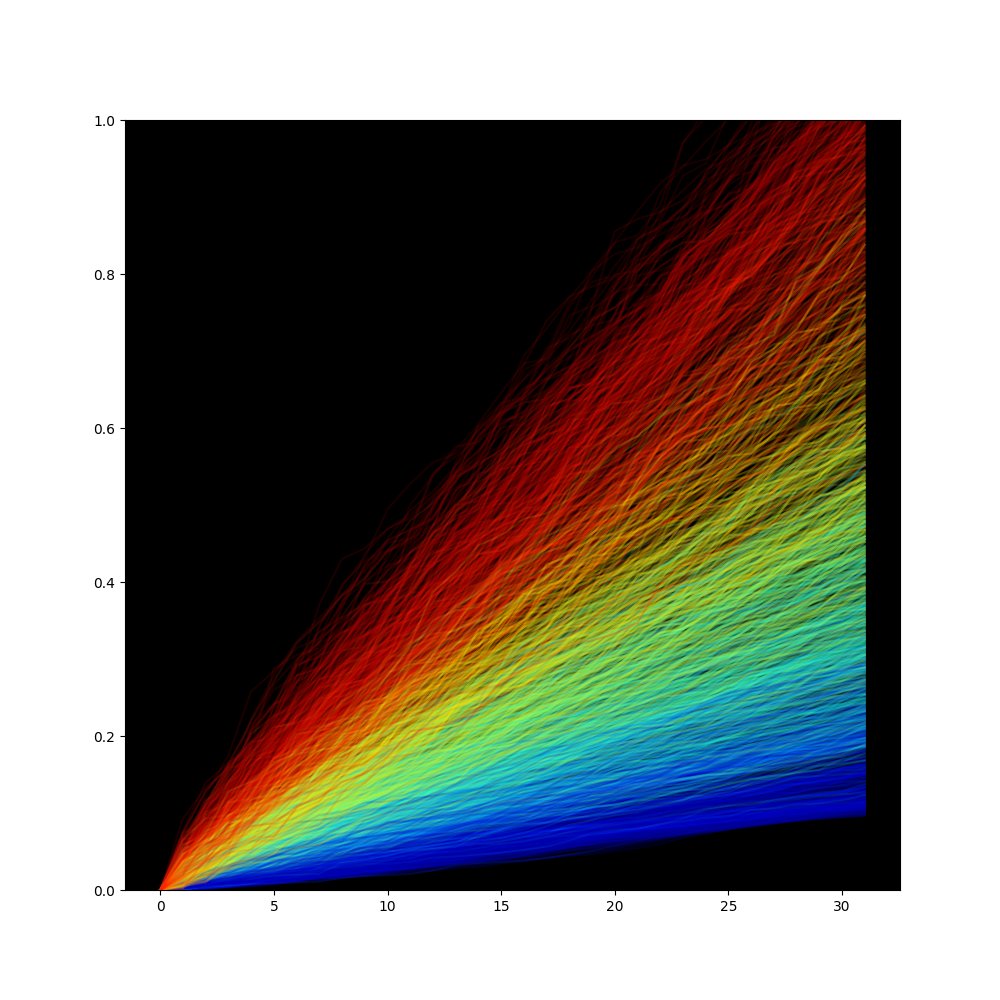

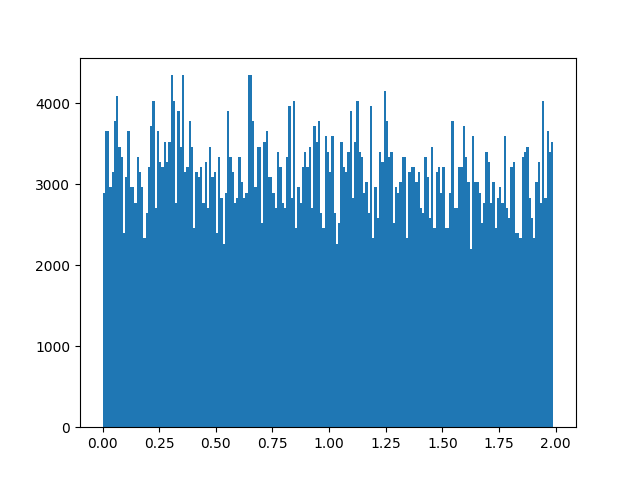

In [6]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_facecolor("black")
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

for i in range(0, 2000):
    color = color_seq[int(input_label[i]/2. * 255)]
    ax.plot(input_data[i], color=color, alpha=0.15, zorder=-1)
#ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.figure()
plt.hist(input_label, bins=np.arange(0, 2, 0.01))

In [26]:
input_data = np.array(input_data).reshape(-1, 1, T, 1)
input_label = np.array(input_label).reshape(-1, 1)
input_data, input_label = shuffle(input_data, input_label)

train_input = input_data[:int(input_data.shape[0] * 0.8)]
train_label = input_label[:int(input_data.shape[0] * 0.8)]
val_input = input_data[int(input_data.shape[0] * 0.8):]
val_label = input_label[int(input_data.shape[0] * 0.8):]

train_input, train_label = shuffle(train_input, train_label)
val_input, val_label = shuffle(val_input, val_label)

In [27]:
print(f'train_reg_shape:{train_input.shape}\n',
      f'train_label_shape:{train_label.shape}\n'
      f'val_reg_shape:{val_input.shape}\n',
      f'val_label_shape:{val_label.shape}\n'
     )

train_reg_shape:(504000, 1, 32, 1)
 train_label_shape:(504000, 1)
val_reg_shape:(126000, 1, 32, 1)
 val_label_shape:(126000, 1)



In [28]:
# Shape [batch, time, features] => [batch, time, lstm_units]
reg_input = keras.Input(shape=(1, None, 1), name="reg_signals")


x = layers.ConvLSTM1D(filters=32, kernel_size=2, strides=1, padding='same', dropout=0.1)(reg_input)
x = layers.ReLU()(x)
x = layers.Bidirectional(layers.LSTM(32, dropout=0.1))(x)

x = layers.Flatten()(x)
reg_dense = layers.Dense(units=2, activation='relu')(x)
reg_last_layer = layers.Dense(units=1)(reg_dense)

reg_model = keras.Model(
    inputs=[reg_input],
    outputs=[reg_last_layer],
    name='anomalous_regression'
)

In [29]:
reg_model.compile(loss=tf.keras.losses.MeanSquaredError(name='mean_squared_error'),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3/2),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                          ]
                 )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=50,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True,
                                                  start_from_epoch=15
                                                 )

In [30]:
reg_history = reg_model.fit(x=train_input,
                        y=train_label,
                        validation_data=(val_input, val_label),
                        batch_size=512,
                        epochs=1500,
                        shuffle=True,
                        callbacks=[early_stopping],
                        verbose=2
                       )
reg_model.save(f'./models/reg_model_{T}.keras')
history_dict = reg_history.history
json.dump(history_dict, open(f'./models/reg_history_{T}.json', 'w'))

Epoch 1/1500


2024-05-29 21:42:09.942295: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


985/985 - 49s - loss: 0.1044 - MAE: 0.2130 - val_loss: 0.0494 - val_MAE: 0.1778 - 49s/epoch - 50ms/step
Epoch 2/1500
985/985 - 44s - loss: 0.0423 - MAE: 0.1606 - val_loss: 0.0443 - val_MAE: 0.1691 - 44s/epoch - 45ms/step
Epoch 3/1500
985/985 - 45s - loss: 0.0420 - MAE: 0.1599 - val_loss: 0.0465 - val_MAE: 0.1735 - 45s/epoch - 45ms/step
Epoch 4/1500
985/985 - 46s - loss: 0.0413 - MAE: 0.1584 - val_loss: 0.0442 - val_MAE: 0.1684 - 46s/epoch - 47ms/step
Epoch 5/1500
985/985 - 45s - loss: 0.0411 - MAE: 0.1578 - val_loss: 0.0446 - val_MAE: 0.1685 - 45s/epoch - 46ms/step
Epoch 6/1500
985/985 - 45s - loss: 0.0409 - MAE: 0.1575 - val_loss: 0.0480 - val_MAE: 0.1750 - 45s/epoch - 46ms/step
Epoch 7/1500
985/985 - 44s - loss: 0.0407 - MAE: 0.1568 - val_loss: 0.0453 - val_MAE: 0.1705 - 44s/epoch - 45ms/step
Epoch 8/1500
985/985 - 45s - loss: 0.0406 - MAE: 0.1567 - val_loss: 0.0429 - val_MAE: 0.1647 - 45s/epoch - 45ms/step
Epoch 9/1500
985/985 - 45s - loss: 0.0406 - MAE: 0.1566 - val_loss: 0.0469 - 

Epoch 71/1500
985/985 - 46s - loss: 0.0389 - MAE: 0.1525 - val_loss: 0.0480 - val_MAE: 0.1756 - 46s/epoch - 46ms/step
Epoch 72/1500
985/985 - 45s - loss: 0.0390 - MAE: 0.1525 - val_loss: 0.0493 - val_MAE: 0.1792 - 45s/epoch - 46ms/step
Epoch 73/1500
985/985 - 46s - loss: 0.0390 - MAE: 0.1526 - val_loss: 0.0454 - val_MAE: 0.1715 - 46s/epoch - 47ms/step
Epoch 74/1500
985/985 - 46s - loss: 0.0389 - MAE: 0.1525 - val_loss: 0.0452 - val_MAE: 0.1705 - 46s/epoch - 46ms/step
Epoch 75/1500
985/985 - 46s - loss: 0.0389 - MAE: 0.1525 - val_loss: 0.0467 - val_MAE: 0.1728 - 46s/epoch - 46ms/step
Epoch 76/1500
Restoring model weights from the end of the best epoch: 26.
985/985 - 46s - loss: 0.0389 - MAE: 0.1526 - val_loss: 0.0446 - val_MAE: 0.1689 - 46s/epoch - 47ms/step
Epoch 76: early stopping


In [33]:
regression_model = tf.keras.models.load_model(f'./models/alpha_reg_models/reg_model_{T}.keras')

In [34]:
pred = regression_model.predict(val_input)
print(f'MAE_valid: {np.mean(abs(pred - val_label))}')
grid = np.arange(0, 2, 0.1)
H, xedges, yedges = np.histogram2d(val_label.flatten(), pred.flatten(), bins=(grid, grid))
print(np.hstack((val_label[:10], pred[:10])))

3938/3938 [==============================] - 25s 6ms/step
MAE_valid: 0.16168174595713017
[[0.5106913  0.75135577]
 [1.12864177 1.44301975]
 [1.65796294 1.59810555]
 [1.31636203 1.49843693]
 [0.44606595 0.46796507]
 [0.40445045 0.33299422]
 [0.48810945 0.9033078 ]
 [0.10222666 0.10830063]
 [1.84539335 1.80036771]
 [1.46253335 1.49998057]]


[Text(0.5, 143.58333333333331, 'True alpha'),
 Text(189.58333333333334, 0.5, 'Pred alpha')]

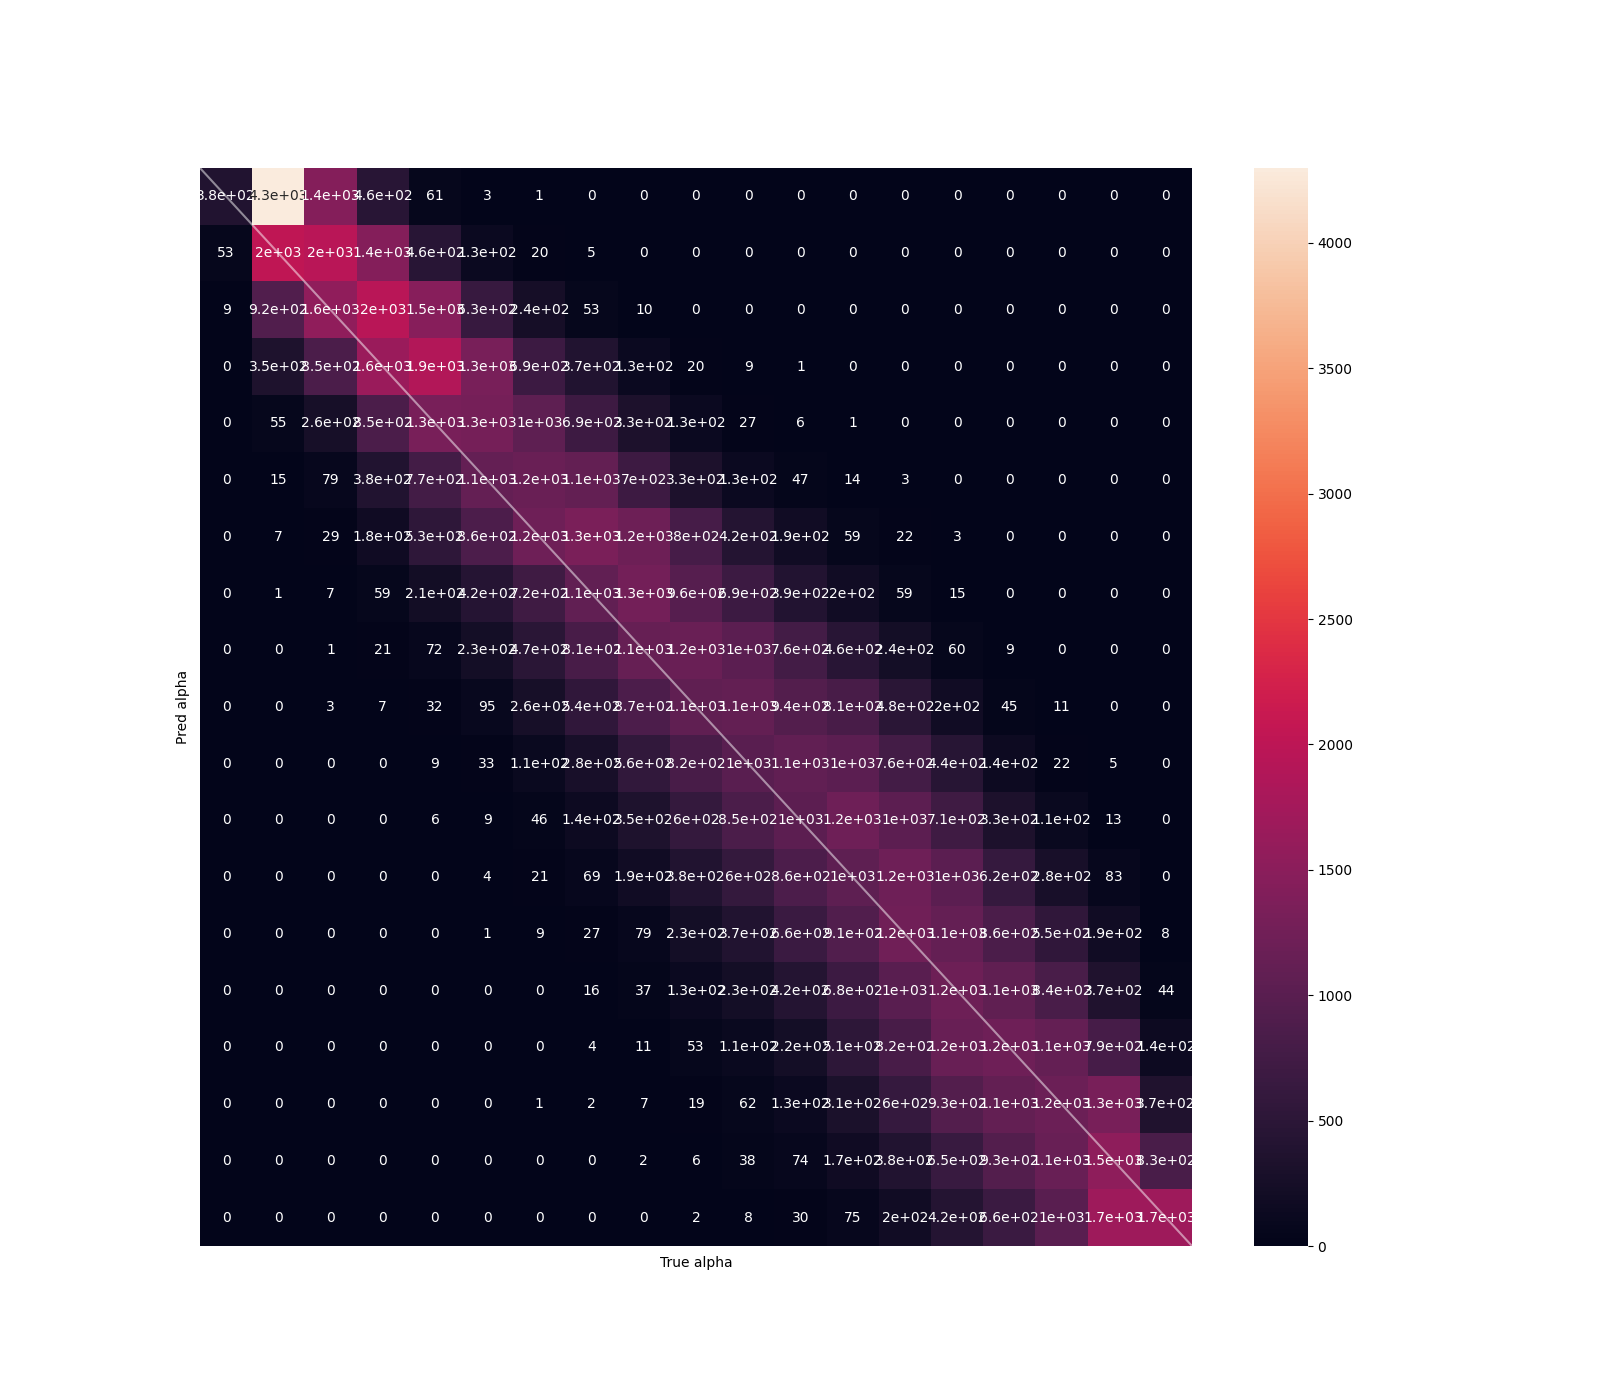

In [36]:
plt.figure(figsize=(16, 14))
ax = sns.heatmap(H, xticklabels=False, yticklabels=False, annot=True)
ax.plot([0, 255],[0, 255], c='white', alpha=0.5, *ax.get_xlim())
ax.set(xlabel='True alpha', ylabel='Pred alpha')